[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape: (5572, 2)
label
0    4825
1     747
Name: count, dtype: int64
Train class counts: [3859  598]
Test class counts: [966 149]
Stump Train acc: 0.8822077630693291
Stump Test acc: 0.8959641255605382
Confusion matrix (test):
 [[930  36]
 [ 80  69]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       966
           1       0.66      0.46      0.54       149

    accuracy                           0.90      1115
   macro avg       0.79      0.71      0.74      1115
weighted avg       0.89      0.90      0.89      1115

Iteration 1
 Weighted error eps: 0.11779223693067094
 Misclassified train indices (subset): [ 14  42  49  50  59  62  86  93  96 100 103 115 121 140 142 157 162 194
 195 196]  (showing up to 20)
 Weights of misclassified (first 20): [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 

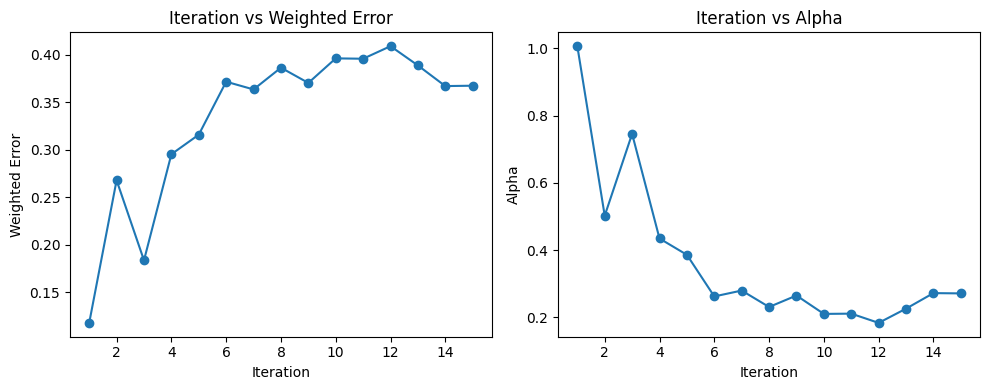

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [3]:
# Q1_SMS_Spam.ipynb / .py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
import re
import nltk
# Uncomment if running first time:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOP = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\S+','', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    tokens = [w for w in s.split() if w not in STOP and len(w)>1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# 1) Load dataset (adjust path to your spam.csv)
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1','v2']].rename(columns={'v1':'label','v2':'text'})
df['label'] = df['label'].map({'ham':0,'spam':1})
print('Shape:', df.shape)
print(df['label'].value_counts())

# Clean texts
df['clean_text'] = df['text'].map(clean_text)

# TF-IDF
tf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tf.fit_transform(df['clean_text']).toarray()
y = df['label'].values

# Train-test split 80/20
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index.values, test_size=0.2, random_state=42, stratify=y)

# Show class distribution
print('Train class counts:', np.bincount(y_train))
print('Test class counts:', np.bincount(y_test))

# Part B: Decision stump baseline
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
y_tr = stump.predict(X_train)
y_te = stump.predict(X_test)
print('Stump Train acc:', accuracy_score(y_train, y_tr))
print('Stump Test acc:', accuracy_score(y_test, y_te))
print('Confusion matrix (test):\n', confusion_matrix(y_test, y_te))
print(classification_report(y_test, y_te))

# Part C: Manual AdaBoost (T=15)
def manual_adaboost(X_train, y_train, X_test, y_test, T=15):
    n = X_train.shape[0]
    # initialize weights
    w = np.ones(n) / n
    learners = []
    learner_alphas = []
    train_preds = np.zeros(n)
    test_preds = np.zeros(X_test.shape[0])
    err_list = []
    alpha_list = []

    for t in range(1, T+1):
        # Train stump with sample_weight
        clf = DecisionTreeClassifier(max_depth=1, random_state=42)
        clf.fit(X_train, y_train, sample_weight=w)
        pred = clf.predict(X_train)
        miss = (pred != y_train).astype(int)
        # weighted error
        eps = np.dot(w, miss) / w.sum()
        # numerical stability
        eps = np.clip(eps, 1e-10, 1-1e-10)
        alpha = 0.5 * np.log((1 - eps) / eps)

        # Log misclassified sample indices & their weights
        mis_idx = np.where(miss==1)[0]
        print(f"Iteration {t}")
        print(" Weighted error eps:", eps)
        print(" Misclassified train indices (subset):", mis_idx[:20], " (showing up to 20)")
        print(" Weights of misclassified (first 20):", w[mis_idx][:20])
        print(" Alpha:", alpha)
        print("-"*40)

        # Update weights
        w = w * np.exp(-alpha * ( (y_train*2-1) * (pred*2-1) )) # but easier below:
        # safer update:
        w = w * np.exp(alpha * (miss * 1)) # increase weight for misclassified (alternative formulation)
        # Normalize
        w = w / w.sum()

        # Save learner
        learners.append(clf)
        learner_alphas.append(alpha)
        err_list.append(eps)
        alpha_list.append(alpha)

        # update aggregated predictions for train and test
        # convert preds to +/-1
        agg_train = sum(a * (clf.predict(X_train)*2-1) for a,clf in zip(learner_alphas, learners))
        agg_test = sum(a * (clf.predict(X_test)*2-1) for a,clf in zip(learner_alphas, learners))
        y_train_hat = (np.sign(agg_train) + 1)//2
        y_test_hat = (np.sign(agg_test) + 1)//2

    # Final metrics
    final_train_acc = accuracy_score(y_train, y_train_hat)
    final_test_acc = accuracy_score(y_test, y_test_hat)
    print("Manual AdaBoost final train acc:", final_train_acc)
    print("Manual AdaBoost final test acc:", final_test_acc)
    print("Confusion matrix (test):")
    print(confusion_matrix(y_test, y_test_hat))
    return learners, learner_alphas, err_list, alpha_list, y_train_hat, y_test_hat

learners, alphas, err_list, alpha_list, y_train_hat, y_test_hat = manual_adaboost(X_train, y_train, X_test, y_test, T=15)

# Plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1,len(err_list)+1), err_list, marker='o')
plt.title('Iteration vs Weighted Error')
plt.xlabel('Iteration'); plt.ylabel('Weighted Error')

plt.subplot(1,2,2)
plt.plot(range(1,len(alpha_list)+1), alpha_list, marker='o')
plt.title('Iteration vs Alpha'); plt.xlabel('Iteration'); plt.ylabel('Alpha')
plt.tight_layout()
plt.show()

# Part D: sklearn AdaBoost
sk_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                                 n_estimators=100, learning_rate=0.6, random_state=42)
sk_adaboost.fit(X_train, y_train)
y_tr_sk = sk_adaboost.predict(X_train)
y_te_sk = sk_adaboost.predict(X_test)
print('sklearn AdaBoost train acc:', accuracy_score(y_train, y_tr_sk))
print('sklearn AdaBoost test acc:', accuracy_score(y_test, y_te_sk))
print('Confusion matrix (test):\n', confusion_matrix(y_test, y_te_sk))
print(classification_report(y_test, y_te_sk))


In [12]:
# Q3_WISDM_Adaboost.ipynb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load WISDM raw file
# The WISDM raw file typically has lines like:
# 33,Walking,1426702792000,-0.318,-7.667,5.667
# But some versions join samples; adapt parser accordingly
data_path = 'WISDM_ar_v1.1_raw.txt'
rows = []
with open(data_path, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        # ignore trailing ; or broken lines
        try:
            parts = line.split(',')
            if len(parts) < 6:
                continue
            user = parts[0]
            activity = parts[1]
            ts = int(parts[2])
            x = float(parts[3])
            y = float(parts[4])
            z = float(parts[5])
            rows.append((user, activity, ts, x, y, z))
        except:
            continue

df = pd.DataFrame(rows, columns=['user','activity','timestamp','x','y','z'])
print('Loaded rows:', len(df))
df = df.dropna()

# Map activities to binary
vigorous = set(['Jogging','Upstairs','jogging','Upstairs'])
light = set(['Walking','WalkingDownstairs','Downstairs','Walk','Sitting','Standing','Downstairs','Walking'])
# Normalize activity names
df['activity_clean'] = df['activity'].str.strip().str.lower()
df['label'] = df['activity_clean'].apply(lambda s: 1 if ('jog' in s or 'up' in s) else 0)

# Create windows (e.g. 2-second windows using timestamp or fixed sample count)
# For simplicity, create non-overlapping windows of 50 samples per window
window_size = 50
features = []
labels = []
grouped = df.groupby('activity_clean')
# simpler: slide windows over each activity separately
for (user, activity), g in df.groupby(['user','activity_clean']):
    arr = g[['x','y','z']].values
    lab = int(('jog' in activity or 'up' in activity))
    ns = len(arr) // window_size
    for i in range(ns):
        w = arr[i*window_size:(i+1)*window_size]
        feat = [
            w.mean(axis=0).tolist(),
            w.std(axis=0).tolist(),
            w.min(axis=0).tolist(),
            w.max(axis=0).tolist(),
            np.mean(np.linalg.norm(w, axis=1)),  # mean magnitude
            np.std(np.linalg.norm(w, axis=1))
        ]
        flat = np.hstack([feat[0], feat[1], feat[2], feat[3], feat[4:],])
        features.append(flat)
        labels.append(lab)

X = np.array(features)
y = np.array(labels)
print('Feature matrix shape:', X.shape)

# Train test split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Part B: Decision stump baseline
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
print('Stump train acc', accuracy_score(y_train, stump.predict(X_train)))
print('Stump test acc', accuracy_score(y_test, stump.predict(X_test)))
print(confusion_matrix(y_test, stump.predict(X_test)))
print(classification_report(y_test, stump.predict(X_test)))

# Part C: Manual AdaBoost (T=20) reuse manual_adaboost function from Q1 (adapted)
def manual_adaboost_numeric(X_train, y_train, X_test, y_test, T=20):
    n = X_train.shape[0]
    w = np.ones(n) / n
    learners = []
    alphas = []
    for t in range(1, T+1):
        clf = DecisionTreeClassifier(max_depth=1, random_state=42)
        clf.fit(X_train, y_train, sample_weight=w)
        pred = clf.predict(X_train)
        miss = (pred != y_train).astype(int)
        eps = np.dot(w, miss) / w.sum()
        eps = np.clip(eps, 1e-10, 1-1e-10)
        alpha = 0.5 * np.log((1 - eps) / eps)

        mis_idx = np.where(miss==1)[0]
        print(f"Iteration {t}, eps={eps:.4f}, alpha={alpha:.4f}")
        print(" mis idx (first 20):", mis_idx[:20])
        print(" weights of mis idx (first 20):", w[mis_idx][:20])
        # update weights using textbook formula:
        y_signed = y_train * 2 - 1
        pred_signed = pred * 2 - 1
        w = w * np.exp(-alpha * y_signed * pred_signed)
        w = w / w.sum()

        learners.append(clf)
        alphas.append(alpha)

    # final aggregation
    agg_train = sum(a * (clf.predict(X_train)*2-1) for a,clf in zip(alphas, learners))
    agg_test = sum(a * (clf.predict(X_test)*2-1) for a,clf in zip(alphas, learners))
    y_train_hat = (np.sign(agg_train)+1)//2
    y_test_hat = (np.sign(agg_test)+1)//2
    print('Manual AdaBoost Train acc', accuracy_score(y_train, y_train_hat))
    print('Manual AdaBoost Test acc', accuracy_score(y_test, y_test_hat))
    print('Confusion matrix (test):\n', confusion_matrix(y_test, y_test_hat))
    return learners, alphas

learners_wisdm, alphas_wisdm = manual_adaboost_numeric(X_train, y_train, X_test, y_test, T=20)

# Part D: sklearn AdaBoost
adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                         n_estimators=100, learning_rate=1.0, random_state=42)
adb.fit(X_train, y_train)
print('sklearn AdaBoost train acc', accuracy_score(y_train, adb.predict(X_train)))
print('sklearn AdaBoost test acc', accuracy_score(y_test, adb.predict(X_test)))
print(confusion_matrix(y_test, adb.predict(X_test)))
print(classification_report(y_test, adb.predict(X_test)))


FileNotFoundError: [Errno 2] No such file or directory: 'WISDM_ar_v1.1_raw.txt'